In [2]:
!gdown 1aEr4pmVQm0Ot9aJM3C7QBAuHhRuugdGD
!gdown 1esbmlPMJyGGZmdXQbP9p_EbkdgBodxot

Downloading...
From (original): https://drive.google.com/uc?id=1aEr4pmVQm0Ot9aJM3C7QBAuHhRuugdGD
From (redirected): https://drive.google.com/uc?id=1aEr4pmVQm0Ot9aJM3C7QBAuHhRuugdGD&confirm=t&uuid=39188bdc-57c2-4ea8-859b-e326cfd5f5c9
To: /content/best_model.pth
100% 293M/293M [00:04<00:00, 66.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1esbmlPMJyGGZmdXQbP9p_EbkdgBodxot
From (redirected): https://drive.google.com/uc?id=1esbmlPMJyGGZmdXQbP9p_EbkdgBodxot&confirm=t&uuid=5aad7be7-719a-48ee-aa2c-37dbcac1c3cd
To: /content/lroc_color_poles_modified.tif
100% 1.50G/1.50G [00:12<00:00, 123MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Data/Moon_Image_Augmentation

/content/drive/.shortcut-targets-by-id/1_idUjvkWgpchl5NsSEBkKfNYFLfAPEaw/Data/Moon_Image_Augmentation


#Images Loading
##Make necessary changes for sizes here only
###By default, the sizes with (252, 900) have been implemented

In [ ]:
import cv2
import numpy as np

el=input('Enter element: ')

el_gray_i = 255-cv2.imread(f'extrapolated/{el}.png', cv2.IMREAD_GRAYSCALE)
el_h_i, el_w_i = el_gray_i.shape

moon_high= cv2.resize(cv2.imread('/content/lroc_color_poles_modified.tif', cv2.IMREAD_GRAYSCALE), (9000, 4500))[4500*22//100:4500*78//100, :]
m_h, m_w = moon_high.shape

# Before this line, ensure that both the images are cropped by same percentage
####################################################################
moon_low=cv2.resize(moon_high, (el_w_i, el_h_i))
moon_low=cv2.resize(moon_low, (m_w, m_h), cv2.INTER_NEAREST)
#the size is kept same but the resolution in kms is made poor matching the elemental

el_gray_train=cv2.resize(el_gray_i, (m_w, m_h), cv2.INTER_NEAREST)


Enter element: Si


(2520, 9000) (2520, 9000) (252, 900) (2520, 9000)


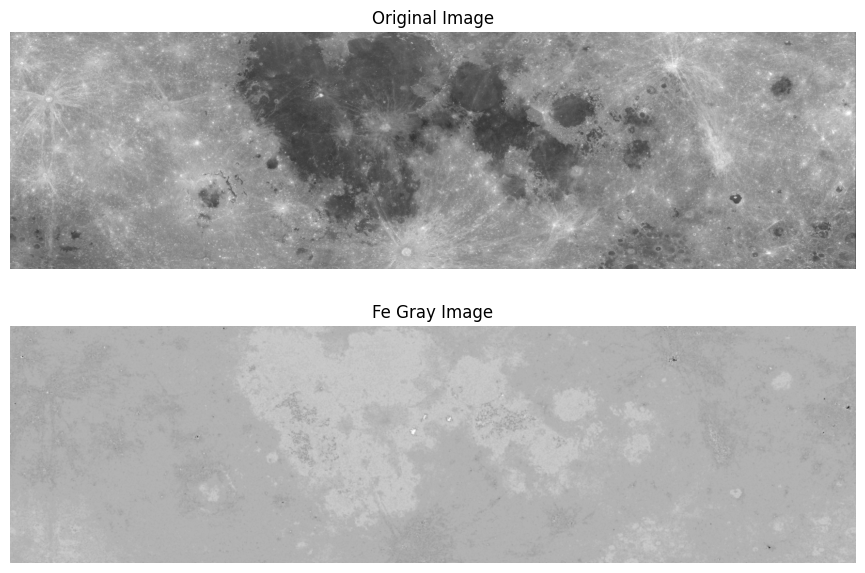

In [ ]:
import matplotlib.pyplot as plt
print(moon_low.shape, moon_high.shape, el_gray_i.shape, el_gray_train.shape)

plt.figure(figsize=(24,14))
plt.subplot(221)
plt.imshow(moon_high, cmap='grey')
plt.title('Original Image')
plt.axis('off')

plt.subplot(121)
plt.imshow(el_gray_train, cmap='grey')
plt.title(f'{el} Gray Image')
plt.axis('off')
plt.show()

#Trainable Data Patches generation function

In [ ]:
import numpy as np
import random

def divide_images_into_patches(image_low, image_high, patch_size=256, num_patches=1000):
    """
    Divide two images into patches of size `patch_size x patch_size` such that the patches
    correspond to the same coordinates in both images. Overlap is introduced only when necessary
    to cover the entire image. If the total patches are less than `num_patches`, additional patches
    are randomly selected from the original patches.

    Parameters:
        image_low (numpy.ndarray): First input image (low resolution or lower intensity).
        image_high (numpy.ndarray): Second input image (high resolution or higher intensity).
        patch_size (int): Size of the patches (default: 256).
        num_patches (int): Total number of patches to generate (default: 1000).

    Returns:
        tuple: Two numpy arrays containing patches for image_low and image_high respectively,
               and a boolean mask indicating which patches are original.
    """

    assert image_low.shape == image_high.shape, "Both images must have the same dimensions"
    height, width = image_low.shape
    patches_low = []
    patches_high = []
    is_original_patch = []  # Tracks whether a patch is original or randomly added

    # Calculate coordinates to cover the full image with minimal overlap
    y_coords = list(range(0, height - patch_size + 1, patch_size)) + ([height - patch_size] if height % patch_size != 0 else [])
    x_coords = list(range(0, width - patch_size + 1, patch_size)) + ([width - patch_size] if width % patch_size != 0 else [])

    # Extract patches based on calculated coordinates
    for y in y_coords:
        for x in x_coords:
            patch_low = image_low[y:y + patch_size, x:x + patch_size]
            patch_high = image_high[y:y + patch_size, x:x + patch_size]
            if patch_low.shape[:2] == (patch_size, patch_size):  # Only keep full patches
                patches_low.append(patch_low)
                patches_high.append(patch_high)
                is_original_patch.append(True)

    patches_low = np.array(patches_low)
    patches_high = np.array(patches_high)
    print(len(patches_low))
    # If fewer patches than required, randomly generate more
    if len(patches_low) < num_patches:
        additional_indices = random.choices(range(len(patches_low)), k=num_patches - len(patches_low))
        patches_low = np.concatenate((patches_low, patches_low[additional_indices]), axis=0)
        patches_high = np.concatenate((patches_high, patches_high[additional_indices]), axis=0)
        is_original_patch.extend([False] * (num_patches - len(is_original_patch)))

    return patches_low, patches_high, np.array(is_original_patch)




import numpy as np

def stitch_images_from_patches(patches_low, patches_high, is_original_patch, original_height, original_width, patch_size=256):
    """
    Stitch patches back together to reconstruct two original images (low and high resolution).
    Overlapping regions are overwritten with the values from the latest patch.

    Parameters:
        patches_low (numpy.ndarray): Array of patches for the low-resolution image.
        patches_high (numpy.ndarray): Array of patches for the high-resolution image.
        is_original_patch (numpy.ndarray): Boolean mask indicating which patches are original.
        original_height (int): Height of the original images.
        original_width (int): Width of the original images.
        patch_size (int): Size of the patches (default: 256).

    Returns:
        tuple: Two numpy arrays representing the reconstructed low-resolution and high-resolution images.
    """
    # Initialize stitched images as grayscale (2D arrays)
    stitched_low = np.zeros((original_height, original_width), dtype=np.uint8)
    stitched_high = np.zeros((original_height, original_width), dtype=np.uint8)

    patch_idx = 0

    # Calculate coordinates to cover the full image with minimal overlap
    y_coords = list(range(0, original_height - patch_size + 1, patch_size)) + ([original_height - patch_size] if original_height % patch_size != 0 else [])
    x_coords = list(range(0, original_width - patch_size + 1, patch_size)) + ([original_width - patch_size] if original_width % patch_size != 0 else [])

    for y in y_coords:
        for x in x_coords:
            if patch_idx >= len(patches_low):
                break
            # Directly copy the latest patch into the region, overwriting any overlaps
            patch_low = patches_low[patch_idx].squeeze()  # Ensure patch is 2D
            patch_high = patches_high[patch_idx].squeeze()  # Ensure patch is 2D

            stitched_low[y:y + patch_size, x:x + patch_size] = patch_low
            stitched_high[y:y + patch_size, x:x + patch_size] = patch_high

            patch_idx += 1

    return stitched_low, stitched_high

# Example usage
# Assume patches_low, patches_high, and is_original_patch are numpy arrays from the divide_images_into_patches function
# reconstructed_low, reconstructed_high = stitch_images_from_patches(
#     patches_low, patches_high, is_original_patch, original_height, original_width
# )


#Test Data Patches generation function

In [ ]:
import numpy as np
import random

def divide_image_into_patches(image_test, patch_size=256, num_patches=1000):
    """
    Divide a grayscale image into patches of size `patch_size x patch_size`. Overlap is introduced only when necessary
    to cover the entire image. If the total patches are less than `num_patches`, additional patches are randomly
    selected from the original patches.

    Parameters:
        image_test (numpy.ndarray): Input grayscale image.
        patch_size (int): Size of the patches (default: 256).
        num_patches (int): Total number of patches to generate (default: 1000).

    Returns:
        tuple: Numpy array containing patches for the image and a boolean mask indicating which patches are original.
    """
    height, width = image_test.shape
    patches_test = []
    is_original_patch = []  # Tracks whether a patch is original or randomly added

    # Calculate coordinates to cover the full image with minimal overlap
    y_coords = list(range(0, height - patch_size + 1, patch_size)) + ([height - patch_size] if height % patch_size != 0 else [])
    x_coords = list(range(0, width - patch_size + 1, patch_size)) + ([width - patch_size] if width % patch_size != 0 else [])

    # Extract patches based on calculated coordinates
    for y in y_coords:
        for x in x_coords:
            patch_test = image_test[y:y + patch_size, x:x + patch_size]
            if patch_test.shape == (patch_size, patch_size):  # Only keep full patches
                patches_test.append(patch_test)
                is_original_patch.append(True)

    patches_test = np.array(patches_test)

    # If fewer patches than required, randomly generate more
    if len(patches_test) < num_patches:
        additional_indices = random.choices(range(len(patches_test)), k=num_patches - len(patches_test))
        patches_test = np.concatenate((patches_test, patches_test[additional_indices]), axis=0)
        is_original_patch.extend([False] * (num_patches - len(is_original_patch)))

    return patches_test, np.array(is_original_patch)

def stitch_patches_to_image(patches_test, is_original_patch, original_height, original_width, patch_size=256):
    """
    Stitch the patches back together to reconstruct the original grayscale image, averaging overlapping regions.
    Only original patches (not randomly generated ones) are included in the averaging.

    Parameters:
        patches_test (numpy.ndarray): Array of patches for the image.
        is_original_patch (numpy.ndarray): Boolean mask indicating which patches are original.
        original_height (int): Height of the original image.
        original_width (int): Width of the original image.
        patch_size (int): Size of the patches (default: 256).

    Returns:
        numpy.ndarray: Reconstructed grayscale image.
    """
    stitched_test = np.zeros((original_height, original_width), dtype=np.float32)
    weight_map = np.zeros((original_height, original_width), dtype=np.float32)
    patch_idx = 0

    # Calculate coordinates to cover the full image with minimal overlap
    y_coords = list(range(0, original_height - patch_size + 1, patch_size)) + ([original_height - patch_size] if original_height % patch_size != 0 else [])
    x_coords = list(range(0, original_width - patch_size + 1, patch_size)) + ([original_width - patch_size] if original_width % patch_size != 0 else [])

    for y in y_coords:
        for x in x_coords:
            if patch_idx >= len(patches_test):
                break
            if is_original_patch[patch_idx]:  # Only include original patches in averaging
                patch_test = patches_test[patch_idx]
                stitched_test[y:y + patch_size, x:x + patch_size] += patch_test
                weight_map[y:y + patch_size, x:x + patch_size] += 1
            patch_idx += 1

    # Normalize by the weight map to average overlapping areas
    stitched_test /= np.maximum(weight_map, 1)

    return stitched_test.astype(np.uint8)

# Example usage
# Assume image_test is a numpy array


#Loading Training Patches

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

patches_low, patches_high, ori_np=divide_images_into_patches(moon_low, moon_high)


class MoonDatasetFromNumpy(Dataset):
    def __init__(self, low_patches, high_patches, transform=None):
        assert low_patches.shape[0] == high_patches.shape[0]
        self.low_patches = low_patches
        self.high_patches = high_patches
        self.transform = transform

    def __len__(self):
        return len(self.low_patches)

    def __getitem__(self, idx):
        low_patch = self.low_patches[idx]
        high_patch = self.high_patches[idx]

        # Convert to tensor and optionally apply transforms
        if self.transform:
            low_patch = self.transform(low_patch)
            high_patch = self.transform(high_patch)
        else:
            low_patch = torch.tensor(low_patch, dtype=torch.float32)
            high_patch = torch.tensor(high_patch, dtype=torch.float32)

        return low_patch, high_patch


# Create dataset
train_dataset = MoonDatasetFromNumpy(patches_low, patches_high)

# Create data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Number of samples in the dataset: {len(train_dataset)}")


360
Number of samples in the dataset: 1000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#Model Training and saving weights

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=46f429ff8a7259a0f4c4174603d9d9713d6f714eaa47e0effb19a3b1c2f28838
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=8040ff423eff0e5c5c5514755dba653f311c0430b9194574278a6e36744a32c1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class
class MoonDatasetFromNumpy(Dataset):
    def __init__(self, low_patches, high_patches, transform=None):
        assert low_patches.shape[0] == high_patches.shape[0]
        self.low_patches = low_patches
        self.high_patches = high_patches
        self.transform = transform

    def __len__(self):
        return len(self.low_patches)

    def __getitem__(self, idx):
        low_patch = self.low_patches[idx]
        high_patch = self.high_patches[idx]

        # Normalize patches to [0, 1]
        low_patch = (low_patch - low_patch.min()) / (low_patch.max() - low_patch.min())
        high_patch = (high_patch - high_patch.min()) / (high_patch.max() - high_patch.min())

        # Convert to tensors and add channel dimension
        low_patch = torch.tensor(low_patch, dtype=torch.float32).unsqueeze(0)
        high_patch = torch.tensor(high_patch, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            low_patch = self.transform(low_patch)
            high_patch = self.transform(high_patch)

        return low_patch, high_patch

# # Example numpy arrays for dataset
# low_patches = torch.rand(100, 256, 256).numpy()  # Replace with your data
# high_patches = torch.rand(100, 256, 256).numpy()  # Replace with your data

# Create dataset and dataloader
train_dataset = MoonDatasetFromNumpy(patches_low, patches_high)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize model with output activation as sigmoid
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,  # Single-channel grayscale input
    classes=1,      # Single-channel grayscale output
    activation='sigmoid',  # Output in range [0, 1]
).to(device)

# Loss function (MAE for better stability)
criterion = nn.L1Loss()

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Reduced learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Training loop
num_epochs = 10
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (patches_low, patches_high) in enumerate(pbar):
        patches_low = patches_low.to(device)
        patches_high = patches_high.to(device)

        # Forward pass
        outputs = model(patches_low)
        loss = criterion(outputs, patches_high)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and progress bar
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{scheduler.get_last_lr()[0]:.6f}'})

        # Debug output for first batch
        if i == 0:
            print(f"Input range: {patches_low.min().item()} - {patches_low.max().item()}")
            print(f"Output range: {outputs.min().item()} - {outputs.max().item()}")
            print(f"Ground truth range: {patches_high.min().item()} - {patches_high.max().item()}")
            print(f"Sample loss: {loss.item()}")

    # Step the scheduler
    scheduler.step()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': best_loss,
        }, 'best_model.pth')

print("Training finished!")


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]
Epoch 1/10:   2%|▏         | 2/125 [00:02<01:50,  1.11it/s, loss=0.3006, lr=0.000100]

Input range: 0.0 - 1.0
Output range: 0.04137374833226204 - 0.9987254738807678
Ground truth range: 0.0 - 1.0
Sample loss: 0.2775315046310425


Epoch 1/10: 100%|██████████| 125/125 [00:16<00:00,  7.53it/s, loss=0.0672, lr=0.000100]


Epoch [1/10], Average Loss: 0.1422, LR: 0.000098


Epoch 2/10:   2%|▏         | 2/125 [00:00<00:20,  6.00it/s, loss=0.0775, lr=0.000098]

Input range: 0.0 - 1.0
Output range: 0.06207425892353058 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.06739896535873413


Epoch 2/10: 100%|██████████| 125/125 [00:15<00:00,  8.01it/s, loss=0.0769, lr=0.000098]


Epoch [2/10], Average Loss: 0.0695, LR: 0.000091


Epoch 3/10:   2%|▏         | 2/125 [00:00<00:17,  6.86it/s, loss=0.0587, lr=0.000091]

Input range: 0.0 - 1.0
Output range: 0.032031331211328506 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.07236890494823456


Epoch 3/10: 100%|██████████| 125/125 [00:15<00:00,  8.10it/s, loss=0.0811, lr=0.000091]


Epoch [3/10], Average Loss: 0.0640, LR: 0.000080


Epoch 4/10:   2%|▏         | 2/125 [00:00<00:14,  8.32it/s, loss=0.0624, lr=0.000080]

Input range: 0.0 - 1.0
Output range: 0.03733006492257118 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.059997811913490295


Epoch 4/10: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s, loss=0.0665, lr=0.000080]


Epoch [4/10], Average Loss: 0.0612, LR: 0.000066


Epoch 5/10:   2%|▏         | 2/125 [00:00<00:22,  5.46it/s, loss=0.0551, lr=0.000066]

Input range: 0.0 - 1.0
Output range: 0.031231824308633804 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.05717635154724121


Epoch 5/10: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s, loss=0.0555, lr=0.000066]


Epoch [5/10], Average Loss: 0.0591, LR: 0.000051


Epoch 6/10:   2%|▏         | 2/125 [00:00<00:15,  8.15it/s, loss=0.0523, lr=0.000051]

Input range: 0.0 - 1.0
Output range: 0.020789263769984245 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.05657070502638817


Epoch 6/10: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s, loss=0.0541, lr=0.000051]


Epoch [6/10], Average Loss: 0.0576, LR: 0.000035


Epoch 7/10:   2%|▏         | 2/125 [00:00<00:15,  8.04it/s, loss=0.0884, lr=0.000035]

Input range: 0.0 - 1.0
Output range: 0.02940724417567253 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.06222075968980789


Epoch 7/10: 100%|██████████| 125/125 [00:15<00:00,  7.90it/s, loss=0.0458, lr=0.000035]


Epoch [7/10], Average Loss: 0.0555, LR: 0.000021


Epoch 8/10:   2%|▏         | 2/125 [00:00<00:19,  6.22it/s, loss=0.0536, lr=0.000021]

Input range: 0.0 - 1.0
Output range: 0.03954962641000748 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.05484722554683685


Epoch 8/10: 100%|██████████| 125/125 [00:15<00:00,  7.88it/s, loss=0.0688, lr=0.000021]


Epoch [8/10], Average Loss: 0.0554, LR: 0.000010


Epoch 9/10:   2%|▏         | 2/125 [00:00<00:14,  8.30it/s, loss=0.0570, lr=0.000010]

Input range: 0.0 - 1.0
Output range: 0.024937262758612633 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.04966592788696289


Epoch 9/10: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s, loss=0.0473, lr=0.000010]


Epoch [9/10], Average Loss: 0.0530, LR: 0.000003


Epoch 10/10:   2%|▏         | 2/125 [00:00<00:15,  7.92it/s, loss=0.0475, lr=0.000003]

Input range: 0.0 - 1.0
Output range: 0.02429143339395523 - 1.0
Ground truth range: 0.0 - 1.0
Sample loss: 0.044040024280548096


Epoch 10/10: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s, loss=0.0530, lr=0.000003]


Epoch [10/10], Average Loss: 0.0528, LR: 0.000001
Training finished!


#Run the previous, not the below training as of now

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

# Device configuration (Use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# # Custom Dataset for loading patches_low and patches_high
# class PatchDataset(Dataset):
#     def __init__(self, patches_low, patches_high):
#         self.patches_low = patches_low
#         self.patches_high = patches_high

#     def __len__(self):
#         return len(self.patches_low)

#     def __getitem__(self, idx):
#         fe_image = torch.tensor(self.patches_low[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
#         req_image = torch.tensor(self.patches_high[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
#         return fe_image, req_image


# Create dataset and dataloader
# train_dataset = PatchDataset(patches_low, patches_high)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,  # Adjust to 32 to match input channels
    classes=1,  # Adjust for single-channel output
).to(device)


# Initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 10
# save_dir = 'extrapolated'
best_loss = 1.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Progress bar for batches
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for i, (patches_low, patches_high) in enumerate(pbar):
        # Clear cache if using GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        patches_low = patches_low.to(device)
        patches_high = patches_high.to(device)

        # Forward pass
        outputs = model(patches_low)  # U-Net forward pass
        loss = criterion(outputs, patches_high)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and progress bar before cleanup
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{scheduler.get_last_lr()[0]:.6f}'})

        # Clear variables to free memory
        del outputs
        del loss
        torch.cuda.empty_cache()  # Clear cache again after operations

    # Step the scheduler
    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': best_loss,
        }, 'best_model.pth')

print('Training finished!')


Using device: cuda


Epoch 1/10: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s, loss=21483.3496, lr=0.001000]


Epoch [1/10], Average Loss: 20229.9760, LR: 0.000976


Epoch 2/10: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s, loss=18322.4102, lr=0.000976]


Epoch [2/10], Average Loss: 19304.9407, LR: 0.000905


Epoch 3/10:  41%|████      | 13/32 [00:05<00:08,  2.17it/s, loss=20361.4531, lr=0.000905]


KeyboardInterrupt: 

#Making Predictions with saved weight

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1_idUjvkWgpchl5NsSEBkKfNYFLfAPEaw/Data/Moon_Image_Augmentation'

In [ ]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom Dataset for test data (if needed, but here we're processing single patches)
class PatchDataset(Dataset):
    def __init__(self, patches_low):
        self.patches_low = patches_low

    def __len__(self):
        return len(self.patches_low)

    def __getitem__(self, idx):
        fe_image = torch.tensor(self.patches_low[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return fe_image


# Load the trained model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,  # Adjust to 1 since images are grayscale
    classes=1,  # Single-channel output (grayscale)
).to(device)

# Load the saved model state
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

# Create test dataset and dataloader
# Assuming patches_low is a NumPy array of shape (1000, 256, 256)
patches_test, test_np_ori = divide_image_into_patches(el_gray_train)
test_dataset = PatchDataset(patches_test)  # Use the test patches
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Prepare a list to store predictions
predicted_patches = []

# Loop through test_loader to get predictions
for i, fe_images in enumerate(test_loader):
    fe_images = fe_images.to(device)

    # Get predictions
    with torch.no_grad():
        predicted = model(fe_images)

    # Convert the prediction to NumPy and squeeze to remove extra dimensions
    pred_np = predicted.squeeze().cpu().numpy()

    # Append predictions
    predicted_patches.append(pred_np)

# Convert the list of predictions into a NumPy array
predicted_patches = np.concatenate(predicted_patches, axis=0)

# Now, predicted_patches will contain the output predictions for all input patches
print(f"Predictions shape: {predicted_patches.shape}")


Using device: cuda


<ipython-input-16-e6db3ca67ae9>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth', map_location=device)


Predictions shape: (1000, 256, 256)


In [ ]:
((predicted_patches-np.min(predicted_patches))/np.max(predicted_patches)*255).astype(np.uint8)

array([[[100, 128, 139, ...,  82,  76,  78],
        [109, 144, 140, ...,  64,  39, 118],
        [100, 128, 168, ..., 132, 122, 161],
        ...,
        [ 36,  74, 103, ..., 102,  87, 101],
        [  6,  76, 103, ..., 174, 126, 113],
        [ 15,  44,  38, ...,  79,  72,  98]],

       [[ 99, 128, 137, ...,  84,  78,  79],
        [108, 141, 135, ...,  66,  39, 120],
        [ 98, 123, 165, ..., 136, 125, 166],
        ...,
        [ 37,  74, 102, ..., 102,  86, 101],
        [  8,  76, 102, ..., 174, 126, 114],
        [ 16,  44,  39, ...,  79,  71,  99]],

       [[100, 128, 138, ...,  82,  76,  79],
        [110, 143, 138, ...,  63,  38, 120],
        [100, 126, 168, ..., 134, 123, 163],
        ...,
        [ 36,  74, 103, ..., 102,  86, 101],
        [  6,  76, 103, ..., 174, 126, 114],
        [ 15,  44,  38, ...,  79,  72,  99]],

       ...,

       [[ 98, 124, 134, ...,  82,  76,  79],
        [108, 138, 131, ...,  65,  39, 119],
        [ 96, 120, 162, ..., 136, 123, 162

In [ ]:
stitched_test=stitch_patches_to_image(((predicted_patches-np.min(predicted_patches))/np.max(predicted_patches)*255).astype(np.uint8), test_np_ori,  el_gray_train.shape[0], el_gray_train.shape[1])

(2520, 9000) (2520, 9000) (252, 900) (2520, 9000)


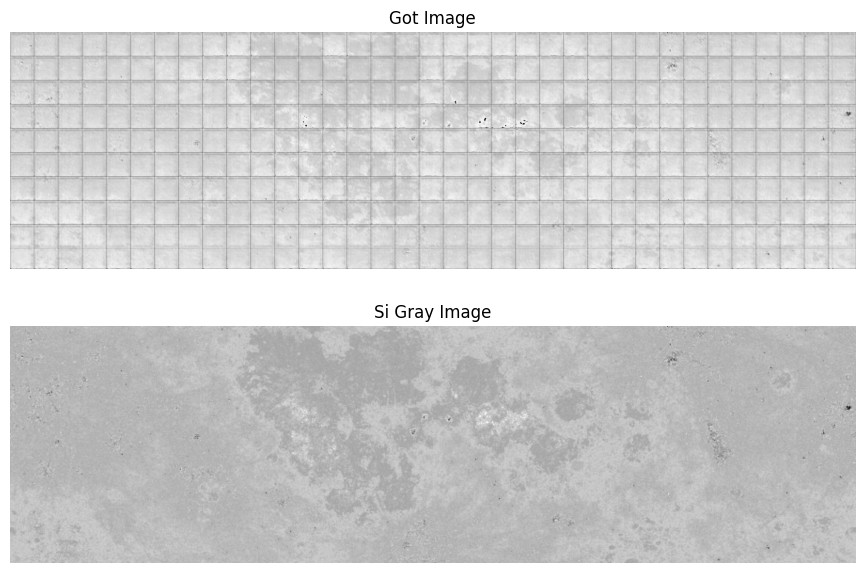

In [ ]:
import matplotlib.pyplot as plt
print(stitched_test.shape, moon_high.shape, el_gray_i.shape, el_gray_train.shape)
cv2.imwrite('extrapolated/Si_enhanced.png', stitched_test)
plt.figure(figsize=(24,14))
plt.subplot(221)
plt.imshow(stitched_test, cmap='grey')
plt.title('Got Image')
plt.axis('off')

plt.subplot(121)
plt.imshow(el_gray_train, cmap='grey')
plt.title(f'{el} Gray Image')
plt.axis('off')
plt.show()